# <font color=blue> Regresión logística vs clasificador bayesiano ingenuo </font>
Compara los métodos de regresión logística y el clasificador bayesiano ingenuo en las siguientes
tareas:

Discute qué modelo seleccionarías y por qué. Todos los modelos deberán ser evaluados con 10
repeticiones de validación cruzada estratificada de 5 particiones.

* Clasificación de spam

In [1]:
#Importamos librerias utiles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import CategoricalNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from scipy.special import expit,logit

#Leemos nuestros datos
spam = pd.read_csv('spam.csv',header=None,sep='\s+')
#Renombramos la ultima columna del dataframe
spam.rename(columns={2000:'Spam?'}, inplace=True)
#imprimimos la info del dataframe para ver si hay datos faltantes
spam.info()
#imprimimos las primeras 5 filas
spam

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Columns: 2001 entries, 0 to Spam?
dtypes: int64(2001)
memory usage: 79.0 MB


,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,Spam?
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
5168,0,0,0,0,3,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5169,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5170,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Vemos que todas las columnas son del tipo int64, por lo que suponemos que no hay datos faltantes.

In [2]:
#buscamos si hay valores en cada fila de la columna Spam? un numero mayor que 1, ya que eso lo consideramos como un
#error en los datos, ya que este df solo toma en cuenta 1 si el correo es spam o 0 si
#no lo es. Para ello primero pasamos la calumna Spam? del df a una matriz numpy.
spm = (spam['Spam?']).to_numpy()
print(np.where(spm > 1))
#vemos que es un array vacio por lo que consideramos que los datos estan limpios.

(array([], dtype=int64),)


Para implementar la validacion cruzada estratificada de 5 particiones debemos asegurarnos que las clases estan desbalanceadas, es decir la cantidad de correos spam y no spam no son iguales. Para ello:

In [3]:
esSpam = np.where(spm == 1)
print('Hay %d correos Spam'%esSpam[0].shape)
noSpam = np.where(spm == 0)
print('Hay %d correos que no son Spam'%noSpam[0].shape)

Hay 1500 correos Spam
Hay 3672 correos que no son Spam


In [4]:
def particionesEstratificadas(particion,y,semilla):
    #definimos un array ordenados_y que contendra los indices de y tales que y queda ordenada de menor a mayor
    #por ejemplo si y es [4,3,2] ordenados_y sera [2,1,0] si lo interpretamos como los indices de y tal que y queda
    #ordenada tenemos que [2,3,4]
    ordenados_y = np.argsort(y)
    #creamos un array no inicializado de la longitud de y
    particiones = np.empty(len(y), dtype=np.int32)
    
    #Para reproducibilidad ajustamos la semilla
    np.random.seed(semilla)
    #iteramos desde cero hasta el tamaño de ordenados_y con paso "particion" (va a ser 5) definido por el usuario
    for i in range(0, ordenados_y.shape[0], particion):
        #define una nueva matriz particion_idx que contendra los valores de ordenados_y (indices de y) desde
        #el paso i hasta i+particion
        particion_idx = ordenados_y[i:i+particion]
        #haz un suffle a los valordes de particion_idx
        #np.random.shuffle(particion_idx)
        #guarda en el array particiones en la posicion dada por los valores de particion_idx un arange hasta la longitud
        #de particion_idx en el momento actual
        particiones[particion_idx] = np.arange(len(particion_idx))
                    
    return particiones

In [5]:
#creamos las particiones estratificadas en el array particiones
particiones = particionesEstratificadas(5,spm,42)
particiones

array([1, 3, 4, ..., 2, 3, 0])

In [6]:
#definimos a como el array que contiene los indices de particiones tales que son igual a 1 (pertenecen a la
#primera particion) (hay 5 del cero a l 4).
a = np.where(particiones ==1)[0]
a

array([   0,    4,    9, ..., 5155, 5160, 5165], dtype=int64)

In [7]:
#Vemos el tamaño de spm en los indices recien calculados
spm[a].shape

(1035,)

In [8]:
#Imprimimos cuantos correos son spam de acuerdo a la particion 1
print('En la particion 1 hay %d correos spam'%np.count_nonzero(spm[a] == 1))
#Imprimimos cuantos correos son spam de acuerdo a la particion 1
print('En la particion 1 hay %d correos no spam'%np.count_nonzero(spm[a] == 0))

En la particion 1 hay 300 correos spam
En la particion 1 hay 735 correos no spam


In [9]:
#Hagamos un ciclo for para comprobar todas las particiones
for fold in range(5):
    a = np.where(particiones == fold)[0]
    #Imprimimos cuantos correos son spam de acuerdo a la particion fold
    print('En la particion %d'  %fold + ' hay %d correos spam' %np.count_nonzero(spm[a] == 1))
    #Imprimimos cuantos correos son spam de acuerdo a la particion 1
    print('En la particion %d' %fold + ' hay %d correos no spam' %np.count_nonzero(spm[a] == 0))

En la particion 0 hay 300 correos spam
En la particion 0 hay 735 correos no spam
En la particion 1 hay 300 correos spam
En la particion 1 hay 735 correos no spam
En la particion 2 hay 300 correos spam
En la particion 2 hay 734 correos no spam
En la particion 3 hay 300 correos spam
En la particion 3 hay 734 correos no spam
En la particion 4 hay 300 correos spam
En la particion 4 hay 734 correos no spam


Vemos que con la particion estratificada, las 5 particiones quedan balanceadas con respecto a las dos clases. Esto es, justo la definicion de k particiones estratificadas. Comprobemos que realmente el balance se hace correctamente, esta comprobacion se va a hacer con la funcion de Scikit-learn ya implementada y vamos a imprimir la cantidad de correos spam y no spam en las particiones.

In [10]:
#definimos nuestras variables independientes
X = (spam.drop(columns='Spam?')).to_numpy()
X.shape

(5172, 2000)

In [11]:
#importa la libreria StratifiedKfold de scikit, para hacer particiones estratificadas
from sklearn.model_selection import StratifiedKFold, KFold
#define 5 particiones con suffle activado y una semilla
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_ix, test_ix in kfold.split(X, spm):
    # selescciona las filas para train y test
    train_X, test_X = X[train_ix], X[test_ix]
    train_y, test_y = spm[train_ix], spm[test_ix]
    # cuenta las longitudes de train y test, divididas segun su clase
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=2937, 1=1200, Test: 0=735, 1=300
>Train: 0=2937, 1=1200, Test: 0=735, 1=300
>Train: 0=2938, 1=1200, Test: 0=734, 1=300
>Train: 0=2938, 1=1200, Test: 0=734, 1=300
>Train: 0=2938, 1=1200, Test: 0=734, 1=300


El resultado es bastante similar. Para el caso de Test los numeros coinciden para una sola particion y para train vemos que son cuatro particiones unidas. Por lo que debemos hacer que una vez pasada la funcion definir quien sera train y quien sera test. Esto se hace junto con la implementacion de las repeticiones.

In [12]:
def validacionEstratificada(x,y,repeticiones,particiones):
    #iteramos sobre las repeticiones
    for i in range(repeticiones):
        #calculamos las particiones con semilla i para procurar que en cada iteracion la variable particion
        #no sea igual a la anterior
        particion = particionesEstratificadas(particiones,y,i)
        #dado que debemos pegar 4 particiones para entrenamiento y 1 para validacion tenemos que itrerar
        #sobre las cuatro particiones
        for fold in range(particiones):
            #Creamos una variable auxiliar (array) que nos va a elegir quienes seran para Train y quienes para test
            z = np.arange(5)
            #aplicamos un suffle a z
            np.random.shuffle(z)
            #creamos arrays auxiliares para evitar hacer el codigo ilegible, en estas arrays vamos a almacenar los
            #indices del array particion tal que pertenecen a una particion determinada
            uno = np.where(particion==z[0])
            dos = np.where(particion==z[1])
            tres = np.where(particion==z[2])
            cuatro = np.where(particion==z[3])
            cinco = np.where(particion==z[4])
            #definimos el conjunto de train al pegar o concatenar a las 4 particiones, mientras que las
            #de test sera unicamente el indice que no quedo dentro de los primeros folds del shuffle
            xTrain = np.concatenate((x[uno],x[dos],x[tres],x[cuatro]),axis=0)
            xTest = x[cinco]
            yTrain = np.concatenate((y[uno],y[dos],y[tres],y[cuatro]),axis=0)
            yTest = y[cinco]
            #pegamos una columna de unos para calcular el parametro theta_0
            unos = np.ones((xTrain.shape[0],1),dtype=float)
            xTrain = np.append(unos,xTrain,axis=1)
            unos = np.ones((xTest.shape[0],1),dtype=float)
            xTest = np.append(unos,xTest,axis=1)
            yield xTrain, yTrain, xTest, yTest        

Para entrenar regresion logistica debemos usar descenso del gradiente. Para ello reutilizaremos el codigo escrito en la libreta Go.ipynb.

In [13]:
#Definimos la funcion que predice los valores, usando la funcion de numpy expit(x)
#esta funcion es la implementacion estable de la funcion sigmoide, con estable nos
#referimos a que cuando ve un valor extrano como infinito devuelve un numero no un nan
#para mas info ver la documentacion: 
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html
def predice(x,theta):
    z = theta.T@x.T
    return expit(z)    

In [14]:
def Entrena(x, y_true, alpha=0.05, steps=100):
    # ejemplos, atributos
    m, n = x.shape
    # inicialización de parámetros con una normal
    Theta = np.random.normal(0, 1, n)
    # lista de histórico de pérdidas
    loss_hist = []
    # ciclio de entrenamiento, para 100 pasos
    for i in range(steps):
        # hacemos prediccion con la theta recien creada y la funcion predice
        y_pred = predice(x,Theta)
        # calculamos la funcion o valores de la funcion de costo, note que agregamos una constante de 1e-9
        #en los argumentos de los logaritmos ya que si no se pone hay inestabilidad numerica por parte del 
        #logaritmo
        loss = -np.average((y_true.T*np.log(y_pred+1e-5) + (1-y_true).T*np.log((1-y_pred+1e-5))))
        # Calculamos el gradiente usando la prediccion expit(x@Theta)
        grad = (x.T @ ((expit(x@Theta)) - y_true)) / m
        # actualizamos parámetros de theta usando el gradiente
        Theta = Theta - alpha * grad
        # ponemos en la lista de historico de perdida el valor de la funcion de perdida
        loss_hist.append(loss)
    #cuando termine de entrenar (100 pasos) regresa el vector de thetas suboptimo y el historial de perdidas    
    return Theta, loss_hist

In [15]:
#definimos la funcion que reescala los datos, definida en las slides 3a_regresion_clasificacion_lineal.pdf
#de la clase, slide 37
def Reescalado(X):
    #definimos una nueva matriz con las dimensiones de la matriz X de entrada y tipo flotante
    xRee=np.zeros((X.shape[0],X.shape[1]),dtype=float)
    #iteramos sobre las columnas de X
    for i in range(X.shape[1]):
        #definimos el maximo y minimo de la columna i usando la funcion de numpy amax y amin
        #que encuentra el valor maximo y minimo de una matriz dada
        maximo = np.amax(X[:,i])
        minimo = np.amin(X[:,i])
        #Una vez definidas el maximo y minimo iteramos sobre cada fila
        for j in range (X.shape[0]):
            #definimos xRee en la fila j, columna i como la resta del valor de X en la misma posicion
            #con el minimo y lo dividimos entre la resta del maximo y minimo.
            xRee[j,i] = (X[j,i]-minimo)/(maximo-minimo)
    #regresamos el array que acabamos de crear
    return xRee

In [16]:
#definimos la funcion que estandariza los datos, definida en las slides 3a_regresion_clasificacion_lineal.pdf
#de la clase, slide 37
def Estandarizacion(X):
    #definimos una nueva matriz con las dimensiones de la matriz X de entrada y tipo flotante
    xEs=np.zeros((X.shape[0],X.shape[1]),dtype=np.float32)
    #iteramos sobre las columnas de X
    for i in range(X.shape[1]):
        #definimos la media y desviacion de la columna i usando la funcion de numpy mean y std
        #que encuentra el valor la media y desviacion de una matriz dada
        media = np.mean(X[:,i])
        desviacion = np.std(X[:,i])
        #Una vez definidas la media y desviacion iteramos sobre cada fila
        for j in range (X.shape[0]):
            #definimos xEs en la fila j, columna i como la resta del valor de X en la misma posicion
            #con la media y lo dividimos entre la desviacion.
            xEs[j,i] = (X[j,i]-media)/(desviacion)
    #regresamos la matriz recien creada
    return xEs

In [17]:
#a nuestras X originales (toda la base de datos) la reescalamos y estandarizamos
#por separado, esto se hace para ver que tanto cambian las predicciones con ambos metodos
xReescalado = Reescalado(X)
xEstandar = Estandarizacion(X)

In [18]:
#Hacemos nuevos df con los datos procesados esto para poder dividir nuestro conjunto a entrenamiento y validacion
#ya que necesitamos un conjunto para que cuando se entrene la regresion logistica podamos predecir y comparar sus 
#salidas
xRe = pd.DataFrame(xReescalado)
xEs = pd.DataFrame(xEstandar)
#Le pegamos a ambos df la columna spm (valores dependientes spam no spam). Dado que no se movieron los 
#indices entonces aseguramos que los df procesados tendran la misma salida para cada fila segun el df original
xRe['Spam?'] = spm
xEs['Spam?'] = spm

In [19]:
#Definimos nuestros conjuntos de entrenamiento y validacion
#train se construye a partir de la funcion sample() donde frac es el porcentaje de los datos
#random_state es la semilla del numero aleatorio, esta funcion por default tiene desactivado
#el ingreso de datos por reemplazo, es decir no se pueden repetir filas
#el conjunto test se construye a partir del train quitando todos los indices que tiene train,
#es decir hace una operacion de conjuntos del conjunto universo Spam resta el conjunto train 
#y guarda lo que resta en test
trainRe = xRe.sample(frac=0.7,random_state=0)
testRe = xRe.drop(trainRe.index)
trainEs = xEs.sample(frac=0.7,random_state=0)
testEs = xEs.drop(trainEs.index)
#reseteamos los indices con la funcion reset_index. drop=True lo usamos para evitar que se
#anada una columna del indice anterior
trainRe.reset_index(drop=True,inplace=True)
trainEs.reset_index(drop=True,inplace=True)
testRe.reset_index(drop=True,inplace=True)
testEs.reset_index(drop=True,inplace=True)

Aqui surge una pregunta importante ¿Por que no usaste particiones estratificadas para dividir tus conjuntos Entrenamiento y Validacion? La respuesta es intuitiva, cada vez que alguien entrena se tienen datos que podemos conocer usando validacion estratificada y otros metodos. Pero cuando a uno le llegan nuevos datos no siempre estos seran tan bonitos como uno quisiera (clases igualmente distribuidas, datos limpios etc). Por esa razon no lo dividi usando estratificada. A partir de los datos de Entrenamiento ahi si se usara la estratificacion de los datos.

In [20]:
#definimos nuestras x e y de entrenamiento y validacion
xEntRe = trainRe.drop(columns='Spam?').to_numpy()
yEntRe = (trainRe['Spam?']).to_numpy()
xValRe = testRe.drop(columns='Spam?').to_numpy()
yValRe = (testRe['Spam?']).to_numpy()
xEntEs = trainEs.drop(columns='Spam?').to_numpy()
yEntEs = (trainEs['Spam?']).to_numpy()
xValEs = testEs.drop(columns='Spam?').to_numpy()
yValEs = (testEs['Spam?']).to_numpy()

In [21]:
#dado que los datos de validacion no seran pasados por la estratificacion que por default agrega una columna
#de unos para calcular las thetas_0. hay que agregar manuealmente estas columnas a los x de validacion
unos = np.ones((xValRe.shape[0],1),dtype=float)
xValRe = np.append(unos,xValRe,axis=1)
unos = np.ones((xValEs.shape[0],1),dtype=float)
xValEs = np.append(unos,xValEs,axis=1)

In [22]:
#para los datos reescalados
#Definimos nuestra matriz de Thetas que seran calculadas por la validacion cruzada estratificada de 10
#repeticiones y 5 particiones, es decir se calcularan 50 vectores thetha, dado que el vector de thetha es de 2001
#valores entonces nuestra matriz contendra 50x2001 valores, Cada fila contendra las thetas encontradas
#para cada una de las validaciones
ThethaRe = np.zeros((50,2001),dtype=np.float64)
#definimos nuestra matriz de perdida que contendra las perdidas de cada entrenamiento por 
#validacion cruzada estratificada dado que se hacen 100 repeticiones habra 100 columnas
#y 50 filas para los 10*5 validaciones, cada fila tendra los errores calculados para cada una de las
#100 thethas calculadas, es decir en 0,0 tendra el error para la primera validacion correspondiente al primer 
#conjunto de thethas calculada
LossiRe = np.zeros((50,100),dtype=np.float64)

In [23]:
#para los datos estandarizados
#Definimos nuestra matriz de Thetas que seran calculadas por la validacion cruzada estratificada de 10
#repeticiones y 5 particiones, es decir se calcularan 50 vectores thetha, dado que el vector de thetha es de 2001
#valores entonces nuestra matriz contendra 50x2001 valores, Cada fila contendra las thetas encontradas
#para cada una de las validaciones
ThethaEs = np.zeros((50,2001),dtype=np.float64)
#definimos nuestra matriz de perdida que contendra las perdidas de cada entrenamiento por 
#validacion cruzada estratificada dado que se hacen 100 repeticiones habra 100 columnas
#y 50 filas para los 10*5 validaciones, cada fila tendra los errores calculados para cada una de las
#100 thethas calculadas, es decir en 0,0 tendra el error para la primera validacion correspondiente al primer 
#conjunto de thethas calculada
LossiEs = np.zeros((50,100),dtype=np.float64)

In [24]:
#entrenamos para los datos reescalados
#definimos la variable auxiliar i que nos ayudara a saber en que fila va a colocar los valores
#de theta y perdida
i=0
#iteramos sobre cada x,y de entrenamiento y validacion que calcula la funcion
#validacion estratificada de 10 repeticiones con 5 particiones
for xTrain, yTrain, xTest, yTest in validacionEstratificada(xEntRe, yEntRe,10,5):
    #en la fila i de Thetha y Lossi colocamos los valores que resultan del entrenamiento de la funcion Entrena
    ThethaRe[i],LossiRe[i]=  Entrena(xTrain,yTrain)
    #aumenta i en 1.
    i+=1

In [25]:
#entrenamos para los datos estandarizados
#definimos la variable auxiliar i que nos ayudara a saber en que fila va a colocar los valores
#de theta y perdida
i=0
#iteramos sobre cada x,y de entrenamiento y validacion que calcula la funcion
#validacion estratificada de 10 repeticiones con 5 particiones
for xTrain, yTrain, xTest, yTest in validacionEstratificada(xEntEs, yEntEs,10,5):
    #en la fila i de Thetha y Lossi colocamos los valores que resultan del entrenamiento de la funcion Entrena
    ThethaEs[i],LossiEs[i]=  Entrena(xTrain,yTrain)
    #aumenta i en 1.
    i+=1

In [26]:
#Para reescalado
#Vamos a calcular la media de los ultimos errores calculados para cada iteracion
#entonces guardaremos en una matriz de 1x50 dichos errores\
LossRe = np.mean(LossiRe,axis=0)

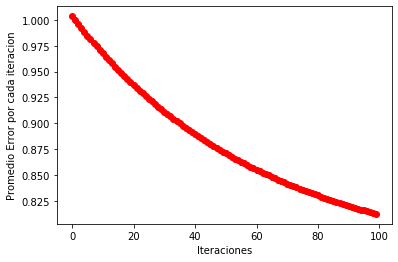

In [27]:
#Para reescalado
#graficamos el error en funcion de las iteraciones usando la lista perdidas
#definida en la forma automatica o forma funcional
plt.figure()
plt.plot(range(len(LossRe)), LossRe, 'ro')
plt.ylabel('Promedio Error por cada iteracion')
plt.xlabel('Iteraciones')
plt.show()

In [28]:
#Para estandarizacion
#Vamos a calcular la media de los ultimos errores calculados para cada iteracion
#entonces guardaremos en una matriz de 1x50 dichos errores\
LossEs = np.mean(LossiEs,axis=0)

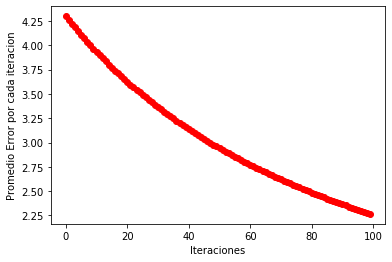

In [29]:
#Para estandarizacion
#graficamos el error en funcion de las iteraciones usando la lista perdidas
#definida en la forma automatica o forma funcional
plt.figure()
plt.plot(range(len(LossEs)), LossEs, 'ro')
plt.ylabel('Promedio Error por cada iteracion')
plt.xlabel('Iteraciones')
plt.show()

Vemos que para los valores estandarizados el error es aproximadamente 4 veces menor comparado con el de estandarizacion

In [30]:
#calculamos las medias de todas las thetas calculadas en la validacion estratificada y entrenamiento
#estas se calculan por columna, este promedio sera nuestro vector de Thetas optimo
#Nore los nombres para reescalado Re y estandarizado Es
ThetaRe = np.mean(ThethaRe,axis=0)
ThetaEs = np.mean(ThethaEs,axis=0)

In [31]:
#una vez entrenado, predecimos nuestros valores de validacion
ypredichRe = predice(xValRe,ThetaRe)
ypredichEs = predice(xValEs,ThetaEs)

In [32]:
#Para el reescalado
#ypredich tendra valores de probabilidad por lo que debemos decidir si es spam o no
#haciendo que si el valor de y en una determinada fila es menor que 0.5 entonces decimos que
#no es spam. y en caso contrario decimos que si es spam
#creamos una nueva matriz que tendra puros ceros o unos y la llamamos prediccion
prediccionRe = np.zeros(ypredichRe.shape,dtype=int)
#iteramos sobre las filas de ypredich
for i in range (ypredichRe.shape[0]):
    #asignamos 0 o 1 segun los valores de cada fila
    z = ypredichRe[i]
    if z<0.5:
        prediccionRe[i]=0
    else:
        prediccionRe[i]=1

In [33]:
#Para el estandarizacion
#ypredich tendra valores de probabilidad por lo que debemos decidir si es spam o no
#haciendo que si el valor de y en una determinada fila es menor que 0.5 entonces decimos que
#no es spam. y en caso contrario decimos que si es spam
#creamos una nueva matriz que tendra puros ceros o unos y la llamamos prediccion
prediccionEs = np.zeros(ypredichEs.shape,dtype=int)
#iteramos sobre las filas de ypredich
for i in range (ypredichEs.shape[0]):
    #asignamos 0 o 1 segun los valores de cada fila
    z = ypredichEs[i]
    if z<0.5:
        prediccionEs[i]=0
    else:
        prediccionEs[i]=1

In [34]:
#Para reescalado
#imprime el accuracy score para el array de prediccion y el original
print(accuracy_score(prediccionRe,yValRe))

0.7332474226804123


In [35]:
#Para estandarizado
#imprime el accuracy score para el array de prediccion y el original
print(accuracy_score(prediccionEs,yValEs))

0.916881443298969


Vemos que el accuracy para el Reescalado es de 0.73, miesntras que para la estandarizacion es de 0.92. Nuevamente el la grafica del error no se correlaciona con el acurracy. Vimos que el error del Reescalado es 4 veces menor que la Estandarizacion pero en el acurracy obtenemos mejores predicciones con la Estandarizacion. Esto puede deberse a que para el reescalado, si x de entrada es 0, entonces el reescalado da cero, es decir es invariante, mientras que para la estandarizacion, si tenemos un valor 0 puede pasar que la estandarizacion sea cero o diferente de cero. Es menos probable que de 0 ya que la media suponemos que es diferente de cero ya que si la media es cero entonces esa palabra nunca aparecio en ningun correo y eso es dato basura. Pero puede suceder.
Ahora calcularemos las curvas roc. de ambas

In [36]:
#definimos funcion de falsos positivos
def radio_falsos_positivos(probabilities, thres):
    return np.mean(probabilities >= thres)

In [37]:
#definimos funcion de verdaderos positivos
def radio_verdaderos_positivos(probabilities, thres):
    return np.mean(probabilities >= thres)

In [38]:
#definimos funcion que calcula curva roc
def roc(probabilities, y):
    positivos = np.where(y == 1)
    negativos = np.where(y == 0)

    rvps = np.zeros(np.unique(probabilities).shape[0])
    rfps = np.zeros(np.unique(probabilities).shape[0])
    
    for i, p in enumerate(np.unique(probabilities)[::-1]):
        rvps[i] = radio_verdaderos_positivos(probabilities[positivos], p)
        rfps[i] = radio_falsos_positivos(probabilities[negativos], p)

    return rvps, rfps

In [39]:
#funcion que calcula el area bajo la curva roc usando la formula de shoelace
def area_poligono(vertices):
    area = 0.0
    n_vert = len(vertices)
    for i in range(n_vert - 1):
        area = area + vertices[i][0] * vertices[i + 1][1]
        area = area - vertices[i + 1][0] * vertices[i][1]

    area = area + vertices[n_vert - 1][0] * vertices[0][1]
    area = area - vertices[0][0] * vertices[n_vert - 1][1]

    return 0.5 * abs(area)

def aucroc(tfp, tvp):
    auc = 0.0
    fprev = 0.0
    vprev = 0.0
    for i,(f,v) in enumerate(zip(tfp, tvp)):
        auc += area_poligono([[fprev, 0], [fprev, vprev], [f, v], [f, 0]])
        fprev = f
        vprev = v

    return auc + area_poligono([[fprev, 0], [fprev, vprev], [1, 1], [1, 0]])

In [40]:
#para Reescalado
#con la funcion que calcula la curva roc le damos de comer la matriz de probabilidades definida previamente
#y el vector de yValidacion (valores reales) y nos regresa el rasdio de verdaderos positivos (TPR) la guardamos en
#la variable rvps y el radio de falsos positivos (FPR)
rvpsRe, rfpsRe = roc(ypredichRe, yValRe)

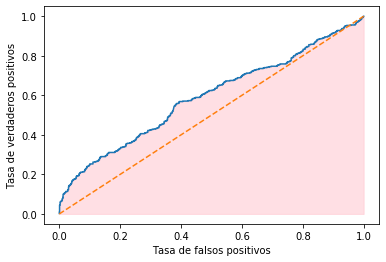

In [41]:
#GRaficamos el TPR en funcion del FPR previamente calculados
plt.plot(rfpsRe, rvpsRe)
plt.plot([0, 1], [0, 1], '--')
plt.fill_between(rfpsRe, rvpsRe, 0, alpha=0.5, color = 'pink')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.show()

In [42]:
#calculamos el area bajo la curva definida por el TPR y FPR para el reescalado
aucroc(rfpsRe, rvpsRe)

0.5903909957756526

In [43]:
#para estandarizacion
#con la funcion que calcula la curva roc le damos de comer la matriz de probabilidades definida previamente
#y el vector de yValidacion (valores reales) y nos regresa el rasdio de verdaderos positivos (TPR) la guardamos en
#la variable rvps y el radio de falsos positivos (FPR)
rvpsEs, rfpsEs = roc(ypredichEs, yValEs)

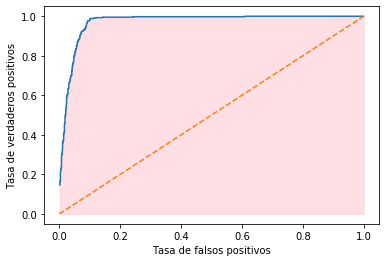

In [44]:
#GRaficamos el TPR en funcion del FPR previamente calculados
plt.plot(rfpsEs, rvpsEs)
plt.plot([0, 1], [0, 1], '--')
plt.fill_between(rfpsEs, rvpsEs, 0, alpha=0.5, color = 'pink')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.show()

In [45]:
#calculamos el area bajo la curva definida por el TPR y FPR para el reescalado
aucroc(rfpsEs, rvpsEs)

0.9701439094610177

Con la curva ROC obtenemos resultados contundentes. El área bajo la curva ROc del reescalado nos dice que este modelo es muy similar a hechar un volado, es decir, el modelo no es muy bueno. Por otro lado con la estandarizacion el area bajo la curva nos confirma que el modelo es bueno para reconocer correos spam y no spam.
Vemos ahora sus curvas de precision exahustividad.

In [46]:
#Para Reescalado
#Para la curva precision-exahustividad sabemos que por definicion el radio de verdaderos positivos
#es igual a la exahustividad, que ya se calculo previamente. Solo basta calcular la precision. Para ello:
#define una matriz llamada positivos cuyos valores corresponden a la posicion para la cual hay un 1 en el 
#vector de validacion
positivosRe = np.where(yValRe == 1)
#define una matriz llamada negativos cuyos valores corresponden a la posicion para la cual hay 1 en el vector
#yPred (predicciones) y ademas en la matriz yVa (valores reales) haya un cero. Esto se hace ya que recordemos
#que los falsos positivos se definen como un resultado que indica la existencia de una condicion cuando en
#realidad no lo es. Traducido a nuestro problema vemos que esto corresponde a el resultado en nuestra prediccion
#que nos dice que si gano un jugador cuando no es verdad. Notemos que la contraparte descrita como no gano cuando
#en realidad si lo hizo corresponde a un falso negativo.
negativosRe = np.where((prediccionRe==1) & (yValRe != prediccionRe))
#definimos nuestro vector de precision que tendra dimension del numero de valores diferentes en la matriz probabilidades
precisionRe = np.zeros(np.unique(ypredichRe).shape[0])

#iteramos i de 0 hasta el tamano de la matriz probabilidades, p se define como el valor de las probabilidad en la
#posicion i
for i, p in enumerate(np.unique(ypredichRe)[::-1]):
    #definimos el float verdaderos positivos como la suma (el total de valores que cumplen la condicion)
    #de aquellos valores en la posicion guardada en el array positivos tal que son mayores o iguales que p 
    truePositivesRe = np.sum(ypredichRe[positivosRe] >= p)
    #definimos el float falsos positivos como la suma (el total de valores que cumplen la condicion)
    #de aquellos valores en la posicion guardada en el array negativos tal que son mayores o iguales que p 
    falsePositivesRe = np.sum(ypredichRe[negativosRe] >= p)
    #guarda en la posicion i del array precision el cociente de los verdaderos positivos entre verdaderos
    #positivos mas falsos positivos (definicion de exahustividad)
    precisionRe[i] = (truePositivesRe)/(falsePositivesRe+truePositivesRe)

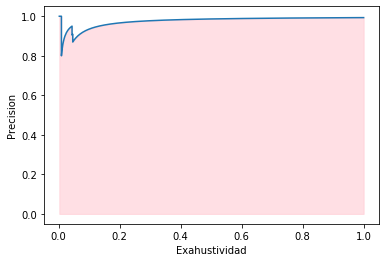

In [47]:
#graficamos la curva precision-exahustividad
plt.plot(rvpsRe,precisionRe)
plt.fill_between(rvpsRe,precisionRe, 0, alpha=0.5, color = 'pink')
plt.xlabel('Exahustividad')
plt.ylabel('Precision')
plt.show()

In [48]:
#Para Estandarizacion
#Para la curva precision-exahustividad sabemos que por definicion el radio de verdaderos positivos
#es igual a la exahustividad, que ya se calculo previamente. Solo basta calcular la precision. Para ello:
#define una matriz llamada positivos cuyos valores corresponden a la posicion para la cual hay un 1 en el 
#vector de validacion
positivosEs = np.where(yValEs == 1)
#define una matriz llamada negativos cuyos valores corresponden a la posicion para la cual hay 1 en el vector
#yPred (predicciones) y ademas en la matriz yVa (valores reales) haya un cero. Esto se hace ya que recordemos
#que los falsos positivos se definen como un resultado que indica la existencia de una condicion cuando en
#realidad no lo es. Traducido a nuestro problema vemos que esto corresponde a el resultado en nuestra prediccion
#que nos dice que si gano un jugador cuando no es verdad. Notemos que la contraparte descrita como no gano cuando
#en realidad si lo hizo corresponde a un falso negativo.
negativosEs = np.where((prediccionEs==1) & (yValEs != prediccionEs))
#definimos nuestro vector de precision que tendra dimension del numero de valores diferentes en la matriz probabilidades
precisionEs = np.zeros(np.unique(ypredichEs).shape[0])

#iteramos i de 0 hasta el tamano de la matriz probabilidades, p se define como el valor de las probabilidad en la
#posicion i
for i, p in enumerate(np.unique(ypredichEs)[::-1]):
    #definimos el float verdaderos positivos como la suma (el total de valores que cumplen la condicion)
    #de aquellos valores en la posicion guardada en el array positivos tal que son mayores o iguales que p 
    truePositivesEs = np.sum(ypredichEs[positivosEs] >= p)
    #definimos el float falsos positivos como la suma (el total de valores que cumplen la condicion)
    #de aquellos valores en la posicion guardada en el array negativos tal que son mayores o iguales que p 
    falsePositivesEs = np.sum(ypredichEs[negativosEs] >= p)
    #guarda en la posicion i del array precision el cociente de los verdaderos positivos entre verdaderos
    #positivos mas falsos positivos (definicion de exahustividad)
    precisionEs[i] = (truePositivesEs)/(falsePositivesEs+truePositivesEs)

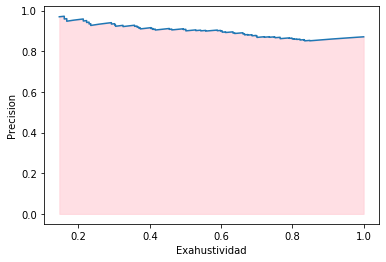

In [49]:
#graficamos la curva precision-exahustividad
plt.plot(rvpsEs,precisionEs)
plt.fill_between(rvpsEs,precisionEs, 0, alpha=0.5, color = 'pink')
plt.xlabel('Exahustividad')
plt.ylabel('Precision')
plt.show()

Entrenemos Ahora un Naive Bayes con nuestros Datos

Intente entrenar con los valores xEntEs y  yEntEs y validar con la siguiente instruccion cati.predict(xValEs)
Pero el compilador lanza error y nunca entendi porque. El error es el siguiente (imagen). Al intentar con el reescalado
da un error similar. Por esta razon la siguiente celda de codigo esta comentada
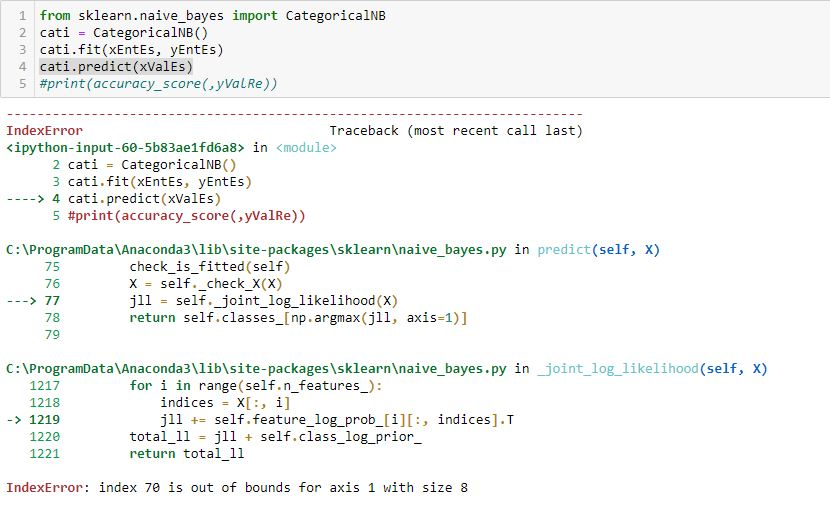

In [50]:
#from sklearn.naive_bayes import CategoricalNB
#cati = CategoricalNB()
#cati.fit(xEntEs, yEntEs)
#cati.predict(xValEs)
#print(accuracy_score(,yValRe))

Con todo el conjunto de datossi se deja entrenar por lo que lo hare con todos aun sabiendo que hay overfitting ya que estoy pasando valores que el clasificador ya conoce.

In [51]:
#redefinimos nuestras x e y de validacion
xValRe = (testRe.drop(columns='Spam?')).to_numpy()
xValEs = testEs.drop(columns='Spam?').to_numpy()

In [52]:
naiveCat = CategoricalNB()
naiveCat.fit(xEstandar,spm)
prediccion = naiveCat.predict(xValEs)

#usamos la funcion accuracy_score entre las variables prediccion e yValid
#tal y como fueron definidos. Esta funcion muestra el porcentaje de clasificaciones buenas
#que hace el modelo con respecto a todas las muestras
print(accuracy_score(prediccion,yValEs))

0.8202319587628866


Aun con overfitting el acurracy es menor que con la regresion logistica con los datos estandarizados.
De esta manera yo escogeria la regresion logistica. Ya que el acurracy score es de 0.92. Tambien el area bajo la curva ROC es de 0.97 y como ya lo discuti en el ejercicio 2 Naive no tiene definido curvas ROC (hasta donde yo se) y esta curva nos da una buena referencia de que tan bueno es el clasificador a la hora de detectar spam.
Por otro lado con la validacion estratificada obtenemos un array de thetas conforme vamos entrenando con diferentes sets de validacion y entrenamiento. Al final las thetas que escogemos son un promedio, esto quiere decir que estamos de alguna manera generalizando nuestro modelo al obtener el promedio de las thetas. Por contra parte Naive solo le da una pasada a los datos y a partir de ahi decide por lo que su generalizacion no es muy buena. Esto lo vemos en su accuracy aun con overfitting el acurracy es menor.
Hablamos de generalizavion con la regresion logistica ya que suponemos que los datos que se usan para entrenar son una representacion general del conjunto de todos los correos spam que podemos encontrar. si los datos no son representativos, entonces la supuesta generalizacion seria mas bien hacer overffiting. Pero este ultimo se descarta ya que con datos que jamas habia visto puede predecir de una forma muy aceptable si son spam o no.

Finalmente para este caso se logro apreciar la importancia del tratamiento de los atributos, cuando creamos un orden (como en el caso de la estandarizacion) el modelo tiende a ser mejor comparado a cuando el orden no esta muy definido o hay atributos que se mantienen muy similares en el dataset (El Reescalado dejo en valor 0 a todas las palabras que no aparecian en un correo determinado). Por lo que podriamos esperar que el rendimiento de un clasificador mejora cuando los atributos no son similares entre si.

Por diversion hacemos regresion logistica con sci kit para una sola pasada de los datos. Vemos que el accuracy es 0.4 puntos mejor que el implementado manualmente. Pero esto puede deberse a que no se hace validacion cruzada estratificada y/o la misma implementacion del algoritmo. Algo que supongo no tiene que ver con el accuracy es el hecho de que el algoritmo aqui implementado es lento mientras que el de scikit es rapido.

In [53]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='none').fit(xEntEs, yEntEs)
prediccions = clf.predict(xValEs)
print(accuracy_score(prediccions,yValEs))

0.9626288659793815


* Clasificacion de tumores de seno